# Kalman Filter Parameter Optimization using Genetic Algorithm

In [1]:
# imports
import numpy as np
from deap import base, creator, tools, algorithms
from KalmanFilter import KalmanFilter
from SignalGenerator import SignalGenerator
import matplotlib.pyplot as plt
import random
import json
import datetime
import os
import multiprocessing
from scoop import futures

## Support Functions Definitions

In [2]:
# Define the evaluation function
def evaluate(individual):
    q_val, r_val = individual
    #f_val, h_val, q_val, r_val = individual
    #F = np.array([[f_val]])
    #H = np.array([[h_val]])
    F = np.array([[1]])
    H = np.array([[1]])
    Q = np.array([[q_val]])
    R = np.array([[r_val]])
    P = np.array([[0]])
    x = np.array([[0]])

    # Add noise to create noisy measurement
    noise_std = random.uniform(0.01, 2)
    noisy_signal = SigGen.add_noise(true_signal, noise_std)
    kf = KalmanFilter(F, H, Q, R, P, x)
    filtered_signal = kf.filter(noisy_signal)
    rmsev = kf.calculate_rms_value_error(true_signal, filtered_signal)/true_signal_rms_value
    _, rmse = kf.calculate_error(true_signal, filtered_signal)
    return rmsev, rmse,

In [3]:
def select_with_elitism_and_diversity(population, n, halloffame, diversity_count=-1, tournsize=3):
    """
    Selects individuals for the next generation by combining elitism, tournament
    selection, and random sampling.

    Parameters:
    -----------
    population : list
        A list of individuals from which to select.
    n : int
        The number of individuals to select.
    halloffame : HallOfFame
        The hall of fame containing the best individuals.
    diversity_count : int, optional  (default=-1 for 10% of the population)
        The number of random individuals to add for diversity.
    tournsize : int, optional
        The tournament size for selection.

    Returns:
    --------
    list
        A new list of individuals for the next generation, containing the
        best individuals from the hall of fame, the winners of the
        tournament selection, and a few random individuals.
    """
    # Number of elite individuals to preserve
    elite_count = len(halloffame)
    # Number of random individuals to add for diversity
    if diversity_count < 0:
        diversity_count = int(0.1 * n)
    # First, use an existing selection (tournament) to choose the rest
    selected = tools.selTournament(population, n - elite_count - diversity_count, tournsize)
    # Then, merge the *halloffame* individuals
    selected.extend(halloffame)
    # Add a few random individuals
    for _ in range(diversity_count):
        selected.append(toolbox.individual())
    return selected

In [4]:
def evolve_with_elitism(pop, cxpb, mutpb, ngen, toolbox):
    """
    Executes a genetic algorithm with elitism, where the best individual is
    preserved between generations.

    Parameters:
    -----------
    pop : list
        A list of individuals representing the population.
    cxpb : float
        The probability of mating two individuals (crossover probability).
    mutpb : float
        The probability of mutating an individual.
    ngen : int
        The number of generations to evolve.
    toolbox : Toolbox
        A DEAP toolbox containing the genetic operators.

    Notes:
    ------
    This function implements a custom evolutionary algorithm that:
    1. Evaluates all individuals in each generation
    2. Preserves the best individual (elitism)
    3. Selects individuals for the next generation
    4. Applies crossover and mutation based on the given probabilities
    5. Adds the elite individual to the offspring
    6. Replaces the population with the new generation

    The toolbox should contain registered functions for:
    - evaluate: to compute fitness values
    - select: to select individuals for reproduction
    - mate: for crossover between individuals
    - mutate: to introduce variation
    - clone: to create copies of individuals
    """
    for gen in range(ngen):
        # Evaluate all individuals
        for ind in pop:
            ind.fitness.values = toolbox.evaluate(ind)

        # Apply elitism: Find the best individual
        best_ind = tools.selBest(pop, k=1)[0]

        # Select the next generation
        offspring = toolbox.select(pop, len(pop) - 1)
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation to offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cxpb:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Add the elite individual to the next generation
        offspring.append(toolbox.clone(best_ind))

        pop[:] = offspring  # Replace the current population with the new generation

## Create a synthetic signal

In [5]:
# Signal parameters
frequency = 480  # Hz
sampling_rate = 20000  # Hz
duration = 0.2  # seconds (200 ms)
amplitude = 0.1
offset = 0.1

SigGen = SignalGenerator(frequency, sampling_rate, duration, amplitude)

# Generate a clean 400 Hz sine wave
true_signal = SigGen.generate_signal('square')
true_signal = SigGen.add_offset(true_signal, offset)

# Add noise to create noisy measurement
noise_std = 0.5
noisy_signal = SigGen.add_noise(true_signal, noise_std)

# Get time vector
time= SigGen.get_time()

## Plot the original, noisy, and reference filtered signals

MSE: 0.051547
RMSE: 0.227041
True Signal RMS Value: 0.140855
Filtered Signal RMS Value: 0.259613
RMS Value Error: 0.118758


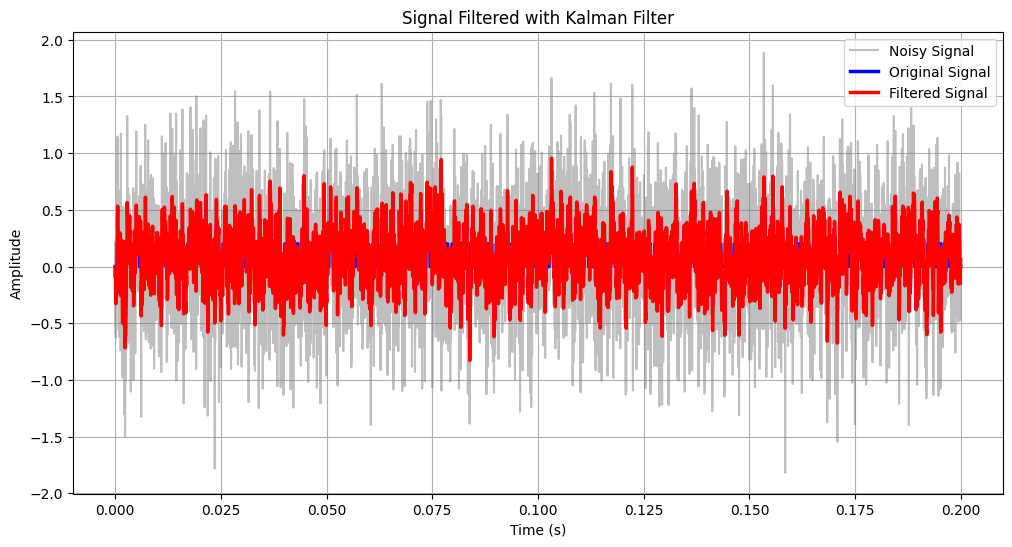

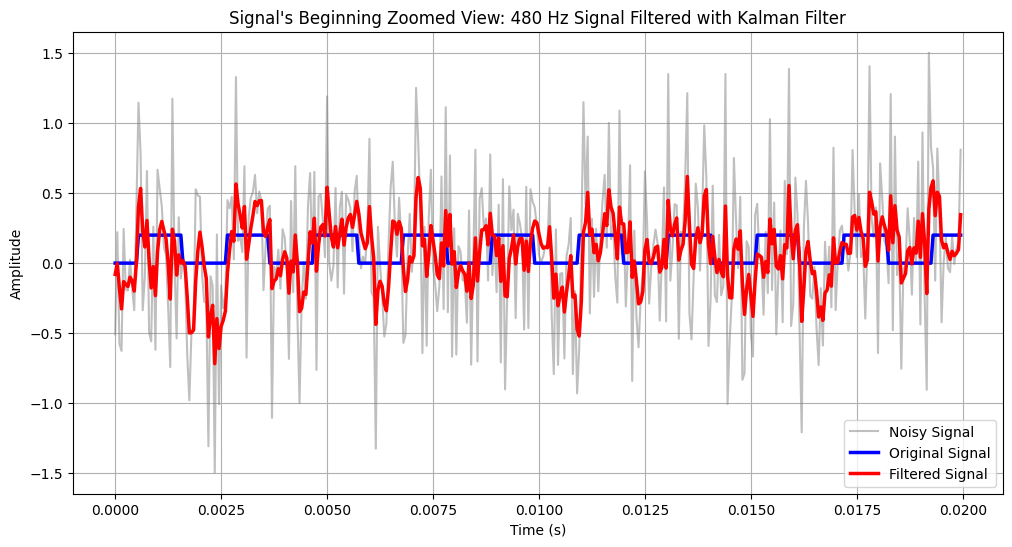

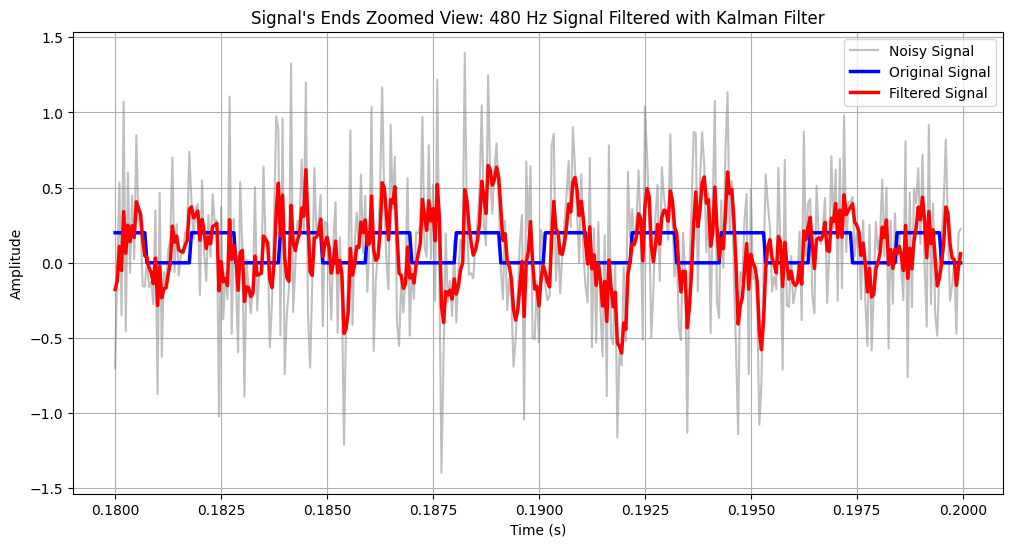

In [6]:
# Initialize Kalman filter
F = np.array([[1]])
H = np.array([[1]])
Q = np.array([[18.679136]])
R = np.array([[100]])
P = np.array([[0]])
x = np.array([[0]])

# Create and apply filter
kf = KalmanFilter(F, H, Q, R, P, x)
filtered_signal = kf.filter(noisy_signal)

# Calculate error metrics
mse, rmse = kf.calculate_error(true_signal, filtered_signal)
print(f'MSE: {mse:.6f}')
print(f'RMSE: {rmse:.6f}')

true_signal_rms_value = kf.calculate_rms_value(true_signal)
filtered_signal_rms_value = kf.calculate_rms_value(filtered_signal)
rms_value_error = kf.calculate_rms_value_error(true_signal, filtered_signal)
print(f'True Signal RMS Value: {true_signal_rms_value:.6f}')
print(f'Filtered Signal RMS Value: {filtered_signal_rms_value:.6f}')
print(f'RMS Value Error: {rms_value_error:.6f}')

# Plot results
kf.plot_results(noisy_signal, true_signal, filtered_signal, time)
kf.plot_results(noisy_signal, true_signal, filtered_signal, time, zoom_end=0.1, title=f'Signal\'s Beginning Zoomed View: {frequency} Hz Signal Filtered with Kalman Filter')
kf.plot_results(noisy_signal, true_signal, filtered_signal, time, zoom_begin=0.9, title=f'Signal\'s Ends Zoomed View: {frequency} Hz Signal Filtered with Kalman Filter')



## Setup the Genetic Algorithm

In [7]:
# Genetic Algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-2.0, -1.0))  # Minimize the RMSv and RMSE
creator.create("Individual", list, fitness=creator.FitnessMin)  # Create individuals as lists

# Create the toolbox for genetic operations
toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, 1e-9, 5e3) # Random float for F, H, Q and R in the range [1e-6, 1e3]
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=2) # Each individual has four parameters: Q and R
#toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=4) # Each individual has four parameters: F, H, Q and R
toolbox.register("population", tools.initRepeat, list, toolbox.individual) # Create the genetic operations
toolbox.register("mate", tools.cxBlend, alpha=0.5) # Blend crossover
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2) # Gaussian mutation
#toolbox.register("select", tools.selTournament, tournsize=3) # Default Tournament selection
toolbox.register("evaluate", evaluate) # Evaluation function to calculate RMSE for each individual

# Preserve the best individual
halloffame = tools.HallOfFame(5)
# Register the custom selection method to include elitism and diversity
toolbox.register("select", select_with_elitism_and_diversity, halloffame=halloffame, diversity_count=-1)  # 10% diversity individuals

# Statistics to keep track of the progress
stats_fit = tools.Statistics(key=lambda ind: ind.fitness.values)
stats_size = tools.Statistics(key=len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

# Use elitism to preserve the best individuals
#toolbox.register("select", tools.selBest)
# Enable parallel processing
#toolbox.register("map", futures.map)
#pool = multiprocessing.Pool()
#toolbox.register("map", pool.map)

## Execute the Genetic Algorithm

In [8]:
# Run the genetic algorithm
popsize = 100 # Population size
ngen = 20  # Number of generations
cxpb = 0.75  # Crossover probability
mutpb = 0.4 # Mutation probability
population = toolbox.population(n=popsize) # Population size

# Run the genetic algorithm
lastPob, logbook = algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=mstats, halloffame=halloffame, verbose=True)

   	      	                        fitness                        	                    size                   
   	      	-------------------------------------------------------	-------------------------------------------
gen	nevals	avg    	gen	max    	min      	nevals	std    	avg	gen	max	min	nevals	std
0  	100   	2.32023	0  	10.8046	0.0133316	100   	2.43686	2  	0  	2  	2  	100   	0  
1  	82    	660.484	1  	38800.3	0.00295157	82    	4147.38	2  	1  	2  	2  	82    	0  
2  	84    	85.896 	2  	14016.6	0.0193932 	84    	997.897	2  	2  	2  	2  	84    	0  
3  	91    	259.488	3  	38884.6	0.00109276	91    	2800.65	2  	3  	2  	2  	91    	0  
4  	92    	47.2288	4  	3612.56	0.00109276	92    	312.588	2  	4  	2  	2  	92    	0  
5  	83    	203.417	5  	28787.9	0.00109276	83    	2066.97	2  	5  	2  	2  	83    	0  
6  	85    	48.3038	6  	8149.04	0.00109276	85    	579.912	2  	6  	2  	2  	85    	0  
7  	86    	31.2891	7  	5179.69	0.002666  	86    	368.562	2  	7  	2  	2  	86    	0  
8  	92    	228.13 	8  	1

In [9]:
# Close the pool
#pool.close()
#pool.join()

In [10]:
#record = mstats.compile(lastPob)
#res_logbook = org_logbook.copy() #   tools.Logbook()
#res_logbook.record(**record)

#res_logbook.header = "gen", "evals", "fitness", "size"
#res_logbook.chapters["fitness"].header = "min", "avg", "max"
#res_logbook.chapters["size"].header = "min", "avg", "max"

#print(res_logbook)

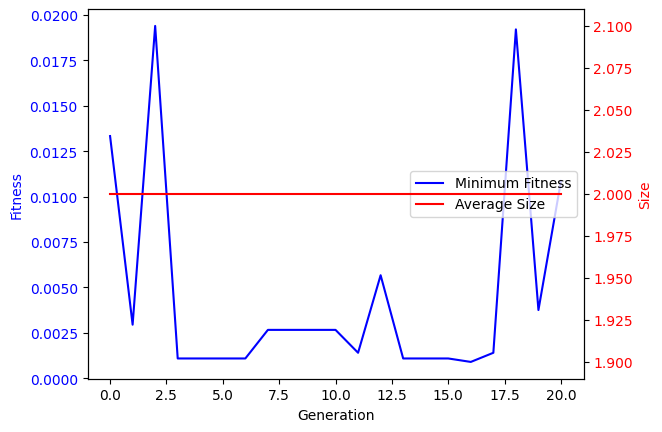

In [11]:
gen = logbook.select("gen")
fit_mins = logbook.chapters["fitness"].select("min")
size_avgs = logbook.chapters["size"].select("avg")

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, fit_mins, "b-", label="Minimum Fitness")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")

ax2 = ax1.twinx()
line2 = ax2.plot(gen, size_avgs, "r-", label="Average Size")
ax2.set_ylabel("Size", color="r")
for tl in ax2.get_yticklabels():
    tl.set_color("r")

lns = line1 + line2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center right")

plt.show()

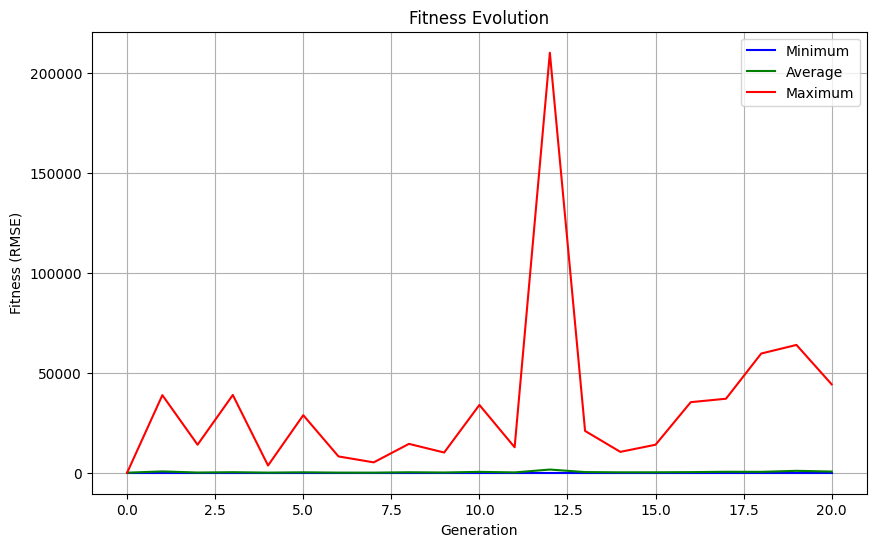

In [12]:
# Plot min, avg, max fitness over generations
plt.figure(figsize=(10, 6))
plt.plot(logbook.select("gen"), logbook.chapters["fitness"].select("min"), 'b-', label='Minimum')
plt.plot(logbook.select("gen"), logbook.chapters["fitness"].select("avg"), 'g-', label='Average')
plt.plot(logbook.select("gen"), logbook.chapters["fitness"].select("max"), 'r-', label='Maximum')
plt.xlabel('Generation')
plt.ylabel('Fitness (RMSE)')
plt.title('Fitness Evolution')
plt.legend()
plt.grid(True)
plt.show()

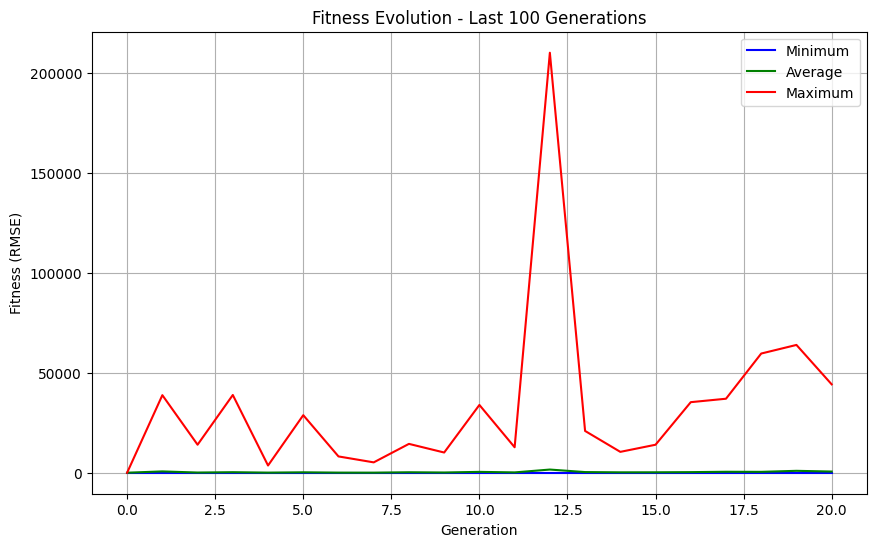

In [13]:
# Plot the last 100 generations
genZoom = 100
plt.figure(figsize=(10, 6))
generations = logbook.select("gen")
num_gens = len(generations)
start_idx = max(0, num_gens - genZoom)  # Start from 'genZoom' generations before the end or 0

# Extract data for the last 100 generations
last_gens = generations[start_idx:]
min_fitness = logbook.chapters["fitness"].select("min")[start_idx:]
avg_fitness = logbook.chapters["fitness"].select("avg")[start_idx:]
max_fitness = logbook.chapters["fitness"].select("max")[start_idx:]

# Plot the fitness curves
plt.plot(last_gens, min_fitness, 'b-', label='Minimum')
plt.plot(last_gens, avg_fitness, 'g-', label='Average')
plt.plot(last_gens, max_fitness, 'r-', label='Maximum')

plt.xlabel('Generation')
plt.ylabel('Fitness (RMSE)')
plt.title(f'Fitness Evolution - Last {genZoom} Generations')
plt.legend()
plt.grid(True)
plt.show()

## Extract the best individuals in the Hall of Fame

In [14]:
print(f"\n============  Hall Of Fame ==============\n")
# best_individual = tools.selBest(population, k=1)[0]
best_individual = halloffame[0]
best_q, best_r = best_individual
#best_f, best_h, best_q, best_r = best_individual
best_fitness = float(best_individual.fitness.values[0])
print("Best Individual:")
print(f"Individual: {best_individual}")
print(f"Best Q: {best_q}, Best R: {best_r}, Fitness: {best_fitness}")
#print(f"Best F: {best_f}, Best H: {best_h}, Best Q: {best_q}, Best R: {best_r}, Fitness: {best_fitness}")

print("\nNext Best Individuals:")
for individual in halloffame[1:]:
    q, r = individual
    #f,h,q, r = individual
    fitness = float(individual.fitness.values[0])
    print(f"Q: {q}, R: {r}, Fitness: {fitness}")
    #print(f"F: {f}, H: {h}, Q: {q}, R: {r}, Fitness: {fitness}")

print(f"\n===== Best Individual Performance =====\n")

# Create filter with optimal parameters
optimal_F = np.array([[1]])
optimal_H = np.array([[1]])
#optimal_F = np.array([[best_f]])
#optimal_H = np.array([[best_h]])
optimal_Q = np.array([[best_q]])
optimal_R = np.array([[best_r]])
P = np.array([[0]])
x = np.array([[0]])
optimal_kf = KalmanFilter(optimal_F, optimal_H, optimal_Q, optimal_R, P, x)
optimal_filtered = optimal_kf.filter(noisy_signal)

# Calculate improvement over original parameters
original_mse, original_rmse = kf.calculate_error(true_signal, filtered_signal)
optimal_mse, optimal_rmse = kf.calculate_error(true_signal, optimal_filtered)
improvement = ((original_rmse - optimal_rmse) / original_rmse) * 100

print(f"Original RMSE: {original_rmse:.6f}")
print(f"Optimal RMSE: {optimal_rmse:.6f}")
print(f"Improvement: {improvement:.2f}%")

true_signal_rms_value = kf.calculate_rms_value(true_signal)
filtered_signal_rms_value = kf.calculate_rms_value(filtered_signal)
rms_value_error = kf.calculate_rms_value_error(true_signal, filtered_signal)
optimal_signal_rms_value = kf.calculate_rms_value(optimal_filtered)
optimal_error = kf.calculate_rms_value_error(true_signal, optimal_filtered)
rms_value_error_improvement = ((rms_value_error - optimal_error) / rms_value_error)*100
print(f'True Signal RMS Value: {true_signal_rms_value:.6f}')
print(f'Filtered Signal RMS Value: {filtered_signal_rms_value:.6f}')
print(f'RMS Value Error: {rms_value_error:.6f}')
print(f'Optimal Signal RMS Value: {optimal_signal_rms_value:.6f}')
print(f'Optimal Signal RMS Error: {optimal_error:.6f}')
print(f'Error Improvement: {rms_value_error_improvement:.2f}%')

print(f"\n=======================================\n")



============  Hall Of Fame ==============

Best Individual:
Individual: [840.9530159549784, 2278.738910920846]
Best Q: 840.9530159549784, Best R: 2278.738910920846, Fitness: 0.0009026451476479677

Next Best Individuals:
Q: 1123.6427397117145, R: 4146.515349704826, Fitness: 0.0010927588394639403
Q: 4037.7548788198824, R: 3115.6383243199284, Fitness: 0.0014058714762520245
Q: 2361.2049010856977, R: 4169.732225149991, Fitness: 0.0026660041619703044
Q: 232.68726860211456, R: 450.8140588411342, Fitness: 0.0029515703393813535

===== Best Individual Performance =====

Original RMSE: 0.227041
Optimal RMSE: 0.265709
Improvement: -17.03%
True Signal RMS Value: 0.140855
Filtered Signal RMS Value: 0.259613
RMS Value Error: 0.118758
Optimal Signal RMS Value: 0.296085
Optimal Signal RMS Error: 0.155230
Error Improvement: -30.71%




## Save the Hall of Fame results to a JSON file

In [15]:
# Create serializable data
hof_json_data = []
for idx, ind in enumerate(halloffame):
    q_val, r_val = ind
    #f_val, h_val, q_val, r_val = ind
    fitness = float(ind.fitness.values[0])

    hof_json_data.append({
        'rank': idx + 1,
        'individual': [q_val, r_val],
        #'individual': [f_val, h_val, q_val, r_val],
        'fitness': fitness
    })

# Create HallOfFame directory if it doesn't exist
hof_dir = "HallOfFame"
if not os.path.exists(hof_dir):
    os.makedirs(hof_dir)
    print(f"Created directory: {hof_dir}")

# Get current date and time in YYYYMMDD-HHMMSS format
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Save to JSON file with timestamp in filename
filename = os.path.join(hof_dir, f'{timestamp}_halloffame_results.json')
with open(filename, 'w') as f:
    json.dump(hof_json_data, f, indent=4)

print(f"Hall of Fame results saved to {filename}")

Hall of Fame results saved to HallOfFame\20250321-131006_halloffame_results.json


## Test The Kalman Filter with the best parameters

Original RMSE: 0.227041
Optimal RMSE: 0.060849
Improvement: 73.20%
True Signal RMS Value: 0.140855
Filtered Signal RMS Value: 0.259613
RMS Value Error: 0.118758
Optimal Signal RMS Value: 0.146096
Optimal Signal RMS Error: 0.005241
Error Improvement: 95.59%


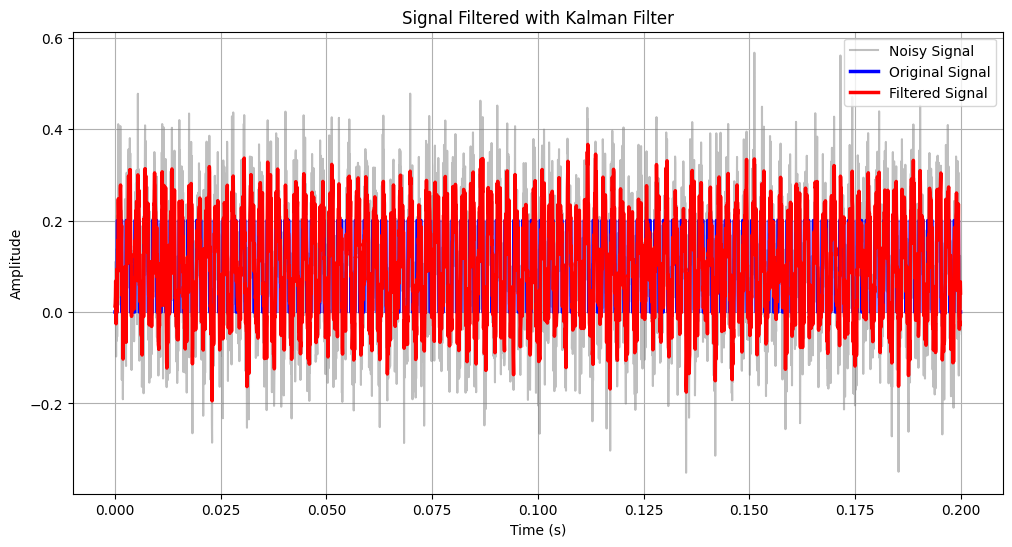

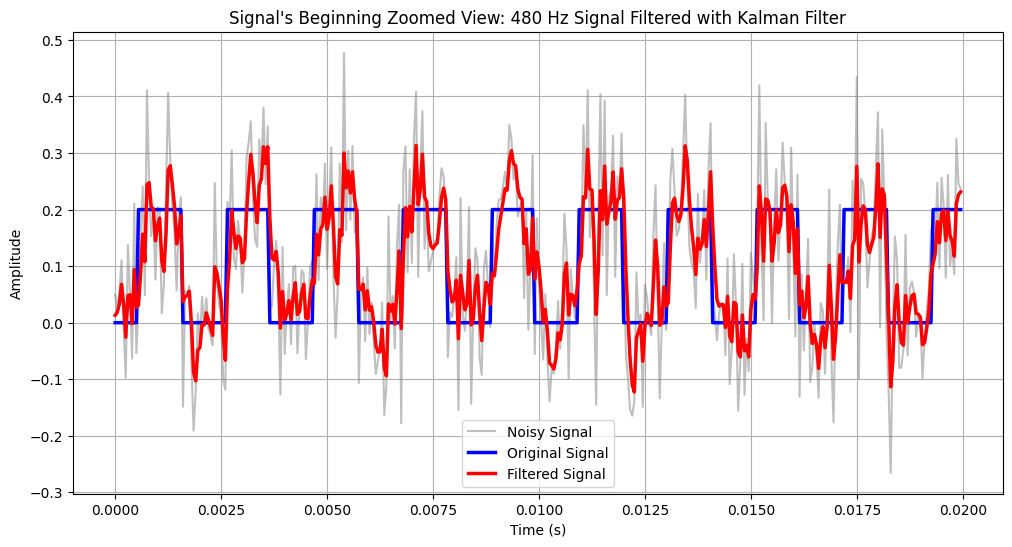

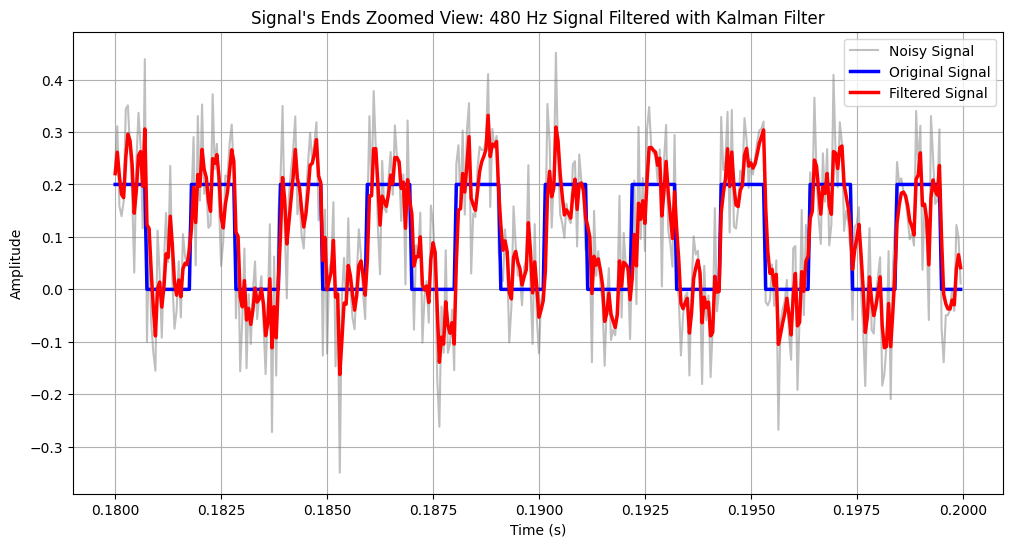

In [16]:
# Add noise to create noisy measurement
noise_std = 0.1
noisy_signal = SigGen.add_noise(true_signal, noise_std)

# Initialize Optimized Kalman filter
optimal_F = np.array([[1]])
optimal_H = np.array([[1]])
#optimal_F = np.array([[best_f]])
#optimal_H = np.array([[best_h]])
optimal_Q = np.array([[best_q]])
optimal_R = np.array([[best_r]])
P = np.array([[0]])  #
x = np.array([[0]])

# Create and apply filter
kf = KalmanFilter(optimal_F, optimal_H, optimal_Q, optimal_R, P, x)
optimal_filtered = kf.filter(noisy_signal)

# Calculate improvement over original parameters
original_mse, original_rmse = kf.calculate_error(true_signal, filtered_signal)
optimal_mse, optimal_rmse = kf.calculate_error(true_signal, optimal_filtered)
improvement = ((original_rmse - optimal_rmse) / original_rmse) * 100

print(f"Original RMSE: {original_rmse:.6f}")
print(f"Optimal RMSE: {optimal_rmse:.6f}")
print(f"Improvement: {improvement:.2f}%")

true_signal_rms_value = kf.calculate_rms_value(true_signal)
filtered_signal_rms_value = kf.calculate_rms_value(filtered_signal)
rms_value_error = kf.calculate_rms_value_error(true_signal, filtered_signal)
optimal_signal_rms_value = kf.calculate_rms_value(optimal_filtered)
optimal_error = kf.calculate_rms_value_error(true_signal, optimal_filtered)
rms_value_error_improvement = ((rms_value_error - optimal_error) / rms_value_error)*100
print(f'True Signal RMS Value: {true_signal_rms_value:.6f}')
print(f'Filtered Signal RMS Value: {filtered_signal_rms_value:.6f}')
print(f'RMS Value Error: {rms_value_error:.6f}')
print(f'Optimal Signal RMS Value: {optimal_signal_rms_value:.6f}')
print(f'Optimal Signal RMS Error: {optimal_error:.6f}')
print(f'Error Improvement: {rms_value_error_improvement:.2f}%')

# Plot results
kf.plot_results(noisy_signal, true_signal, optimal_filtered, time)
kf.plot_results(noisy_signal, true_signal, optimal_filtered, time, zoom_end=0.1, title=f'Signal\'s Beginning Zoomed View: {frequency} Hz Signal Filtered with Kalman Filter')
kf.plot_results(noisy_signal, true_signal, optimal_filtered, time, zoom_begin=0.9, title=f'Signal\'s Ends Zoomed View: {frequency} Hz Signal Filtered with Kalman Filter')